#### Modules Import

In [1]:

import pandas as pd
import mlflow
from sklearn.model_selection import train_test_split
from credit_risk_model.core.settings import settings
from credit_risk_model.utils.project_root import get_project_root
from credit_risk_model.data.load_data import DataLoader
from credit_risk_model.models.train import train_and_tune_models
from credit_risk_model.models.register import register_model
from credit_risk_model.models.plots import plot_training_dashboard

#### MLFOLW config

In [2]:
root = get_project_root()
tracking_path = (root / "mlruns").as_posix()

mlflow.set_tracking_uri(f"file:///{tracking_path}")
mlflow.set_experiment("credit-risk-model")

d:\10Acadamy\Week 4\Task\credit-risk-model\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///D:/10Acadamy/Week 4/Task/credit-risk-model/mlruns/180978035488263883', creation_time=1765995222148, experiment_id='180978035488263883', last_update_time=1765995222148, lifecycle_stage='active', name='credit-risk-model', tags={}>

#### Featured Data Load

In [3]:
name_featured = "features_with_target.parquet"
processed_path = settings.paths.data["processed_dir"] / name_featured

loader = DataLoader(filepath=processed_path, file_type="parquet")
df = loader.load()

df.shape

(95662, 58)

In [4]:
# Remove identifier (not predictive)
df = df.drop(columns=["CustomerId"])

TARGET_COL = "is_high_risk"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((76529, 56), (19133, 56))

#### Model Train, Tune,and Compatre Pipeline

In [5]:
trained_models = train_and_tune_models(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

2025/12/17 23:44:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\10Acadamy\Week 4\Task\credit-risk-model\.venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/12/17 23:47:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\10Acadamy\Week 4\Task\credit-risk-model\.venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\10Acadamy\Week 4\Task\credit-risk-model\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, it

#### Train Result

In [6]:
results = []

for name, info in trained_models.items():
    row = {"model": name}
    row.update(info["metrics"])
    results.append(row)

results_df = pd.DataFrame(results).sort_values(
    by="roc_auc", ascending=False
)

results_df

,model,accuracy,precision,recall,f1_score,roc_auc
2,xgboost,0.995871,0.917708,1.000000,0.957089,0.999789
1,random_forest,0.965191,0.569669,0.997730,0.725248,0.996720
0,logistic_regression,0.946898,0.464038,0.988649,0.631617,0.989262


Select the best-performing model based on ROC-AUC, which is the primary
optimization metric for credit risk.


In [7]:
best_model_name, best_info = max(
    trained_models.items(),
    key=lambda x: x[1]["metrics"]["roc_auc"],
)

best_model_name, best_info["metrics"]


('xgboost',
 {'accuracy': 0.9958710082057178,
  'precision': 0.9177083333333333,
  'recall': 1.0,
  'f1_score': 0.9570885388375883,
  'roc_auc': 0.9997892414508148})

Register the best model in the MLflow Model Registry for downstream
deployment (Task 6).


In [8]:
register_model(
    model_name="credit_risk_model",
    run_id=best_info["run_id"],
)


d:\10Acadamy\Week 4\Task\credit-risk-model\.venv\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
Registered model 'credit_risk_model' already exists. Creating a new version of this model...
2025/12/17 23:49:11 WARNING mlflow.tracking._model_registry.fluent: Run with id bf27156f35fe467a90993013f930b73b has no artifacts at artifact path 'model', registering model based on models:/m-fb277d99fb964527aced773ae1f11918 instead
Created version '4' of model 'credit_risk_model'.


#### Training Compare Dashboard

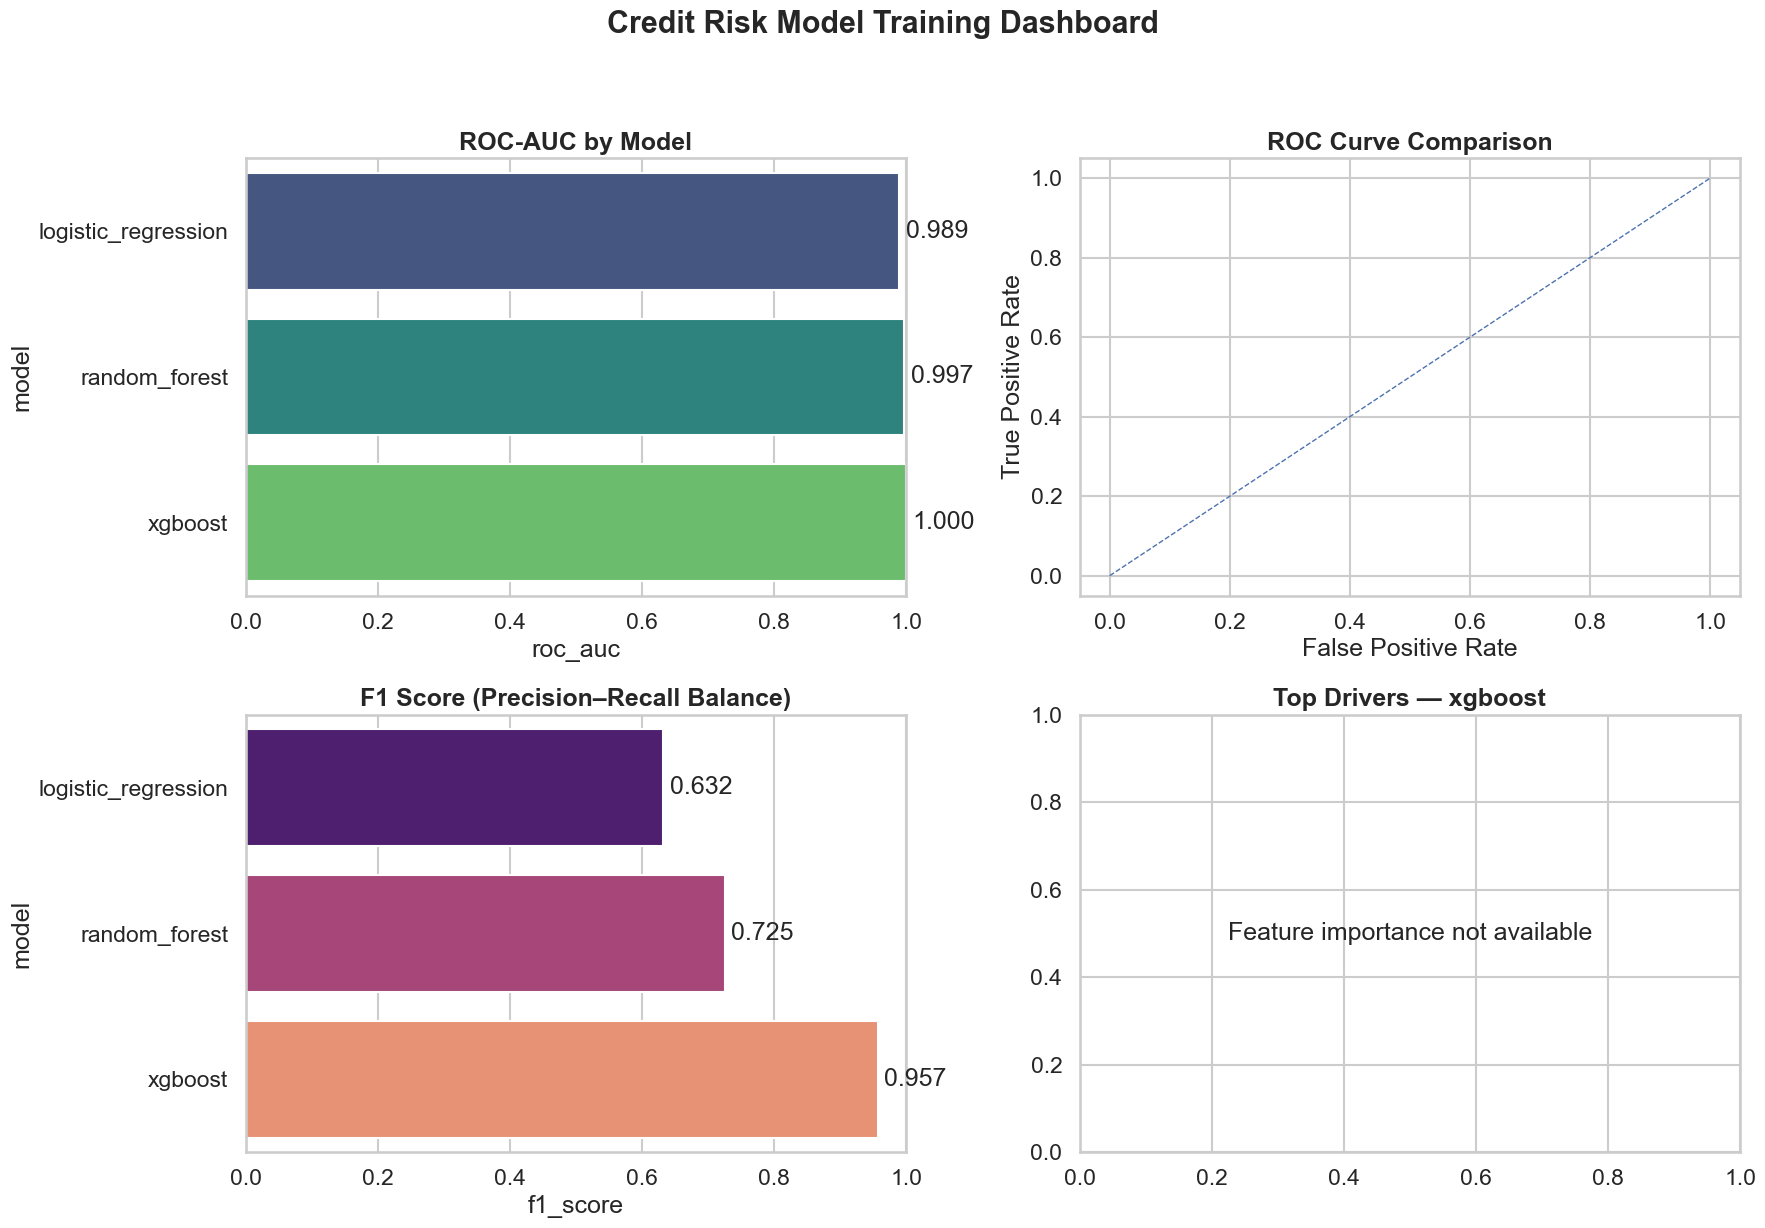

In [9]:
plot_training_dashboard(results_df=results_df, trained_models=trained_models, X_test=X_test,
                        y_test=y_test,)